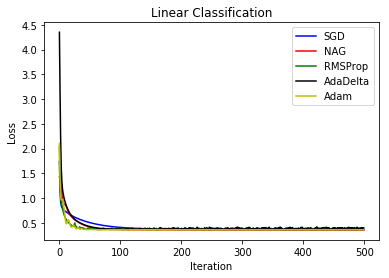

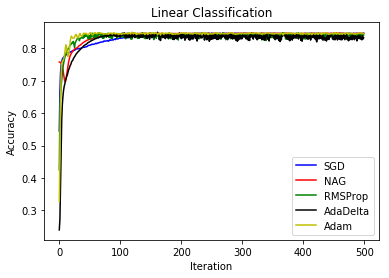

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.datasets import load_svmlight_file

%matplotlib inline

THRESHOD = 0
NUM_ITERATIONS = 500

#load data and divide data set
def get_dataset():
    data_train = load_svmlight_file("./data/a9a")
    data_validation = load_svmlight_file('./data/a9a.t', n_features=123)

    X_train = data_train[0].toarray()
    y_train = data_train[1].reshape(X_train.shape[0], 1)

    X_validation = data_validation[0].toarray()
    y_validation = data_validation[1].reshape(X_validation.shape[0], 1)

    X_train = np.concatenate((np.ones((X_train.shape[0], 1), dtype='float'), X_train), axis=1)
    X_validation = np.concatenate((np.ones((X_validation.shape[0], 1), dtype='float'), X_validation), axis=1)
    
    return X_train, X_validation, y_train, y_validation

def sigmoid(x):
    return 1/(1+np.exp(-x))

#compute hinge loss
def compute_hinge_loss(X,y,W):
    n = X.shape[0]
    zero = np.zeros((n,1))
    pred = np.dot(X,W)
    p = X.dot(W)
    hinge_loss = np.max([zero,1 - y*pred],axis=0)
    return hinge_loss

#compute loss
def compute_loss(X,y,W,C,lambdaa):
    n = X.shape[0]
    hinge_loss = compute_hinge_loss(X,y,W)
    loss = np.sum(hinge_loss)*C/n +  np.dot(W,W.transpose())/2*lambdaa
    return loss[0][0]

#cmpute gradient
def compute_gradient(X,y,W,C,lambdaa):
    hinge_loss = compute_hinge_loss(X,y,W)
    indicator = np.zeros((X.shape[0],1))
    indicator[np.nonzero(hinge_loss)] = 1
    gradient = -np.dot(X.transpose(),y*indicator).sum(axis=1).reshape((X.shape[1], 1))*C/X.shape[0] + W*lambdaa
    return gradient

#compute accuracy
def compute_accuracy(X,y,W,threshold):
    n = X.shape[0]
    pred = np.dot(X,W)
    pred[pred <= threshold] = -1
    pred[pred > threshold] = 1
    count = pred*y
    count[count < 0] = 0
    accuracy = 1.0/n*np.count_nonzero(count)
    return accuracy

def SGD(X_train,y_train,X_validation,y_validation, batch_size=5000,learning_rate=0.00001):
    loss_validation = []
    accuracy_validation = []
    W_SGD = np.random.randn(X_train.shape[1],1)
    
    for i in range(NUM_ITERATIONS):
        sample_index = random.sample(list(np.arange(0, X_train.shape[0])), batch_size)
        X = X_train[sample_index,:]
        y = y_train[sample_index,:]
        loss_validation.append(compute_loss(X_validation,y_validation,W_SGD,C=1.0,lambdaa=0.01))
        accuracy_validation.append(compute_accuracy(X_validation,y_validation,W_SGD,threshold=THRESHOD))
        delta_SGD = compute_gradient(X,y,W_SGD,C=1.0,lambdaa=0.01)
        W_SGD = W_SGD - learning_rate*delta_SGD
    return loss_validation,accuracy_validation
 
def NAG(X_train,y_train,X_validation,y_validation, batch_size=5000,learning_rate=0.00001,gamma=0.9):
    loss_validation = []
    accuracy_validation = []
    W_NAG = np.random.randn(X_train.shape[1],1)
    v = np.zeros((X_train.shape[1],1))
    
    for i in range(NUM_ITERATIONS):
        sample_index = random.sample(list(np.arange(0,X_train.shape[0])),batch_size)
        X = X_train[sample_index,:]
        y = y_train[sample_index,:]
        loss_validation.append(compute_loss(X_validation,y_validation,W_NAG,C=1.0,lambdaa=0.01))
        accuracy_validation.append(compute_accuracy(X_validation,y_validation,W_NAG,threshold=THRESHOD))
        g = compute_gradient(X,y,W_NAG-gamma*v,C=1.0,lambdaa=0.01)
        v = gamma*v+learning_rate*g
        W_NAG = W_NAG - v
        
    return loss_validation,accuracy_validation

def RMSProp(X_train,y_train,X_validation,y_validation, batch_size=5000,learning_rate=0.00001,gamma=0.9,epsilon=1e-8):
    loss_validation = []
    accuracy_validation = []
    W_RMSProp = np.random.randn(X_train.shape[1],1)
    G = np.zeros((X_train.shape[1],1))
    
    for i in range(NUM_ITERATIONS):
        sample_index = random.sample(list(np.arange(0,X_train.shape[0])),batch_size)
        X = X_train[sample_index,:]
        y = y_train[sample_index,:]
        loss_validation.append(compute_loss(X_validation,y_validation,W_RMSProp,C=1.0,lambdaa=0.01))
        accuracy_validation.append(compute_accuracy(X_validation,y_validation,W_RMSProp,threshold=THRESHOD))
        g = compute_gradient(X,y,W_RMSProp,C=1.0,lambdaa=0.01)
        G = gamma*G+(1-gamma)*g*g
        W_RMSProp = W_RMSProp - learning_rate/np.sqrt(G+epsilon)*g
        
    return loss_validation,accuracy_validation

def AdaDelta(X_train,y_train,X_validation,y_validation, batch_size=5000,gamma=0.95,epsilon=1e-8):
    loss_validation = []
    accuracy_validation = []
    W_AdaDelta = np.random.randn(X_train.shape[1],1)
    G = np.zeros((X_train.shape[1],1))
    delta = np.zeros((X_train.shape[1],1))
    
    for i in range(NUM_ITERATIONS):
        sample_index = random.sample(list(np.arange(0,X_train.shape[0])),batch_size)
        X = X_train[sample_index,:]
        y = y_train[sample_index,:]
        loss_validation.append(compute_loss(X_validation,y_validation,W_AdaDelta,C=1.0,lambdaa=0.01))
        accuracy_validation.append(compute_accuracy(X_validation,y_validation,W_AdaDelta,threshold=THRESHOD))
        g = compute_gradient(X,y,W_AdaDelta,C=1.0,lambdaa=0.01)
        G = gamma*G+(1-gamma)*g*g
        delta_w = -np.sqrt(delta+epsilon)/np.sqrt(G+epsilon)*g
        W_AdaDelta = W_AdaDelta+delta_w
        delta = gamma*delta+(1-gamma)*delta_w*delta_w
        
    return loss_validation,accuracy_validation

def Adam(X_train,y_train,X_validation,y_validation, batch_size=5000,learning_rate=0.5,beta=0.9,gamma=0.95,epsilon=1e-8):
    loss_validation = []
    accuracy_validation = []
    W_Adam = np.random.randn(X_train.shape[1],1)
    G = np.zeros((X_train.shape[1],1))
    moments = np.zeros((X_train.shape[1],1))
    
    for i in range(NUM_ITERATIONS):
        sample_index = random.sample(list(np.arange(0,X_train.shape[0])),batch_size)
        X = X_train[sample_index,:]
        y = y_train[sample_index,:]
        loss_validation.append(compute_loss(X_validation,y_validation,W_Adam,C=1.0,lambdaa=0.01))
        accuracy_validation.append(compute_accuracy(X_validation,y_validation,W_Adam,threshold=THRESHOD))
        g = compute_gradient(X,y,W_Adam,C=1.0,lambdaa=0.01)
        moments = beta*moments+(1.0-beta)*g
        G = gamma*G+(1-gamma)*g*g
        alpha = learning_rate*np.sqrt(1.0-gamma**(i+1))/(1-beta**(i+1))
        W_Adam = W_Adam-alpha*moments/np.sqrt(G+epsilon)
        
    return loss_validation,accuracy_validation

def main():
    X_train, X_validation, y_train, y_validation = get_dataset()

    loss_validation = {'SGD': [], 'NAG': [], 'RMSProp': [], 'AdaDelta': [], 'Adam': []}
    accuracy_validation = {'SGD': [], 'NAG': [], 'RMSProp': [], 'AdaDelta': [], 'Adam': []}
    loss_validation['SGD'],accuracy_validation['SGD'] = SGD(X_train, y_train, X_validation, y_validation, batch_size=5000, learning_rate=0.5)
    loss_validation['NAG'],accuracy_validation['NAG'] = NAG(X_train, y_train, X_validation, y_validation, batch_size=5000, learning_rate=0.1, gamma=0.9)
    loss_validation['RMSProp'],accuracy_validation['RMSProp'] = RMSProp(X_train, y_train, X_validation, y_validation, batch_size=5000, learning_rate=0.05, gamma=0.9, epsilon=1e-8)
    loss_validation['AdaDelta'],accuracy_validation['AdaDelta'] = AdaDelta(X_train, y_train, X_validation, y_validation, batch_size=5000, gamma=0.95, epsilon=0.001)
    loss_validation['Adam'],accuracy_validation['Adam'] = Adam(X_train, y_train, X_validation, y_validation, batch_size=5000, learning_rate=0.1, beta=0.9, gamma=0.95, epsilon=1e-8)

    plt.figure(1)
    plot1, = plt.plot(np.arange(0, len(loss_validation['SGD'])), loss_validation['SGD'], 'b')
    plot2, = plt.plot(np.arange(0, len(loss_validation['NAG'])), loss_validation['NAG'], 'r')
    plot3, = plt.plot(np.arange(0, len(loss_validation['RMSProp'])), loss_validation['RMSProp'], 'g')
    plot4, = plt.plot(np.arange(0, len(loss_validation['AdaDelta'])), loss_validation['AdaDelta'], 'k')
    plot5, = plt.plot(np.arange(0, len(loss_validation['Adam'])), loss_validation['Adam'], 'y')

    plt.title('Linear Classification')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend([plot1, plot2, plot3, plot4, plot5], ['SGD', 'NAG', 'RMSProp', 'AdaDelta', 'Adam'])
    
    plt.figure(2)
    plot1, = plt.plot(np.arange(0, len(accuracy_validation['SGD'])), accuracy_validation['SGD'], 'b')
    plot2, = plt.plot(np.arange(0, len(accuracy_validation['NAG'])), accuracy_validation['NAG'], 'r')
    plot3, = plt.plot(np.arange(0, len(accuracy_validation['RMSProp'])), accuracy_validation['RMSProp'], 'g')
    plot4, = plt.plot(np.arange(0, len(accuracy_validation['AdaDelta'])), accuracy_validation['AdaDelta'], 'k')
    plot5, = plt.plot(np.arange(0, len(accuracy_validation['Adam'])), accuracy_validation['Adam'], 'y')

    plt.title('Linear Classification')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend([plot1, plot2, plot3, plot4, plot5], ['SGD', 'NAG', 'RMSProp', 'AdaDelta', 'Adam'])    
    plt.show()
    
if __name__ == "__main__":
    main()